# XKCD Comic Character Labelling

Application of FastAI multi-label image classification on comic panels  
Based on FastAI deep learning tutorials

## Installing Packages

In [0]:
from fastai.vision import *
import numpy as np
import pandas as pd

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

## Creating DataBunch

In [7]:
path= Path('./drive/My Drive/Colab Notebooks/xkcd-labelling/data');
path.ls()

[PosixPath('drive/My Drive/Colab Notebooks/xkcd-labelling/data/urls_xkcd.csv'),
 PosixPath('drive/My Drive/Colab Notebooks/xkcd-labelling/data/labels_xkcd.csv'),
 PosixPath('drive/My Drive/Colab Notebooks/xkcd-labelling/data/2313_wrong_times_table.png'),
 PosixPath('drive/My Drive/Colab Notebooks/xkcd-labelling/data/images')]

In [0]:
tfms = get_transforms(max_rotate=0.,max_zoom=1.,max_warp=0.)

In [0]:
src = (ImageList.from_csv(path, 'labels_xkcd.csv', folder='images')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms,size=256)
        .databunch(bs=16).normalize(imagenet_stats))

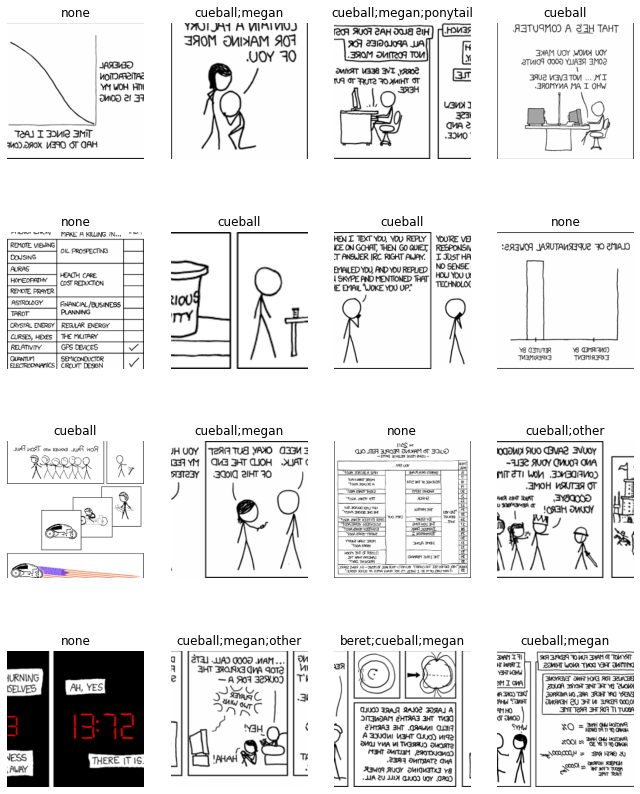

In [51]:
data.show_batch(rows=4,figsize=(9,12))

## Training Model

###  First Pass

In [0]:
arch=models.resnet50;
acc_02 = partial(accuracy_thresh, thresh=0.2);

In [53]:
learn = cnn_learner(data,arch,metrics=acc_02);

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [54]:
learn.lr_find();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


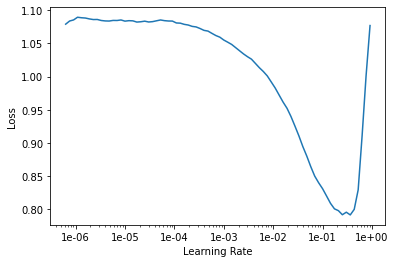

In [15]:
learn.recorder.plot()

In [0]:
lr = 4e-2;

In [55]:
learn.fit_one_cycle(8,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.917661,0.808389,0.467204,00:07
1,0.605130,0.457228,0.840046,00:06
2,0.512342,0.525930,0.896433,00:07
3,0.457391,0.465727,0.884925,00:06
4,0.418047,0.437515,0.890679,00:06
5,0.362022,0.318859,0.876870,00:06
6,0.300737,0.303838,0.889528,00:07
7,0.256572,0.294698,0.883774,00:07


In [0]:
learn.save('stage-1')

###  Fine-Tuning

In [0]:
learn.load('stage-1');
learn.unfreeze();

In [60]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


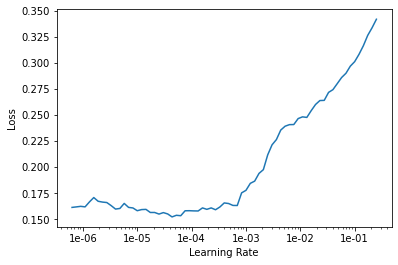

In [61]:
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(5,slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.166061,0.294090,0.883774,00:07
1,0.169305,0.291778,0.882624,00:07
2,0.164198,0.283091,0.886076,00:07
3,0.158251,0.288063,0.881473,00:07
4,0.151653,0.288554,0.878021,00:07


In [0]:
learn.save('stage-2')

### Interpretation

In [71]:
interp=ClassificationInterpretation.from_learner(learn);

17 misclassified samples over 79 samples in the validation set.


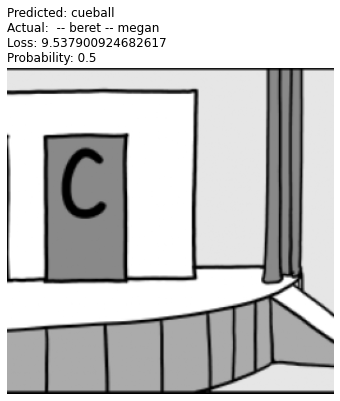

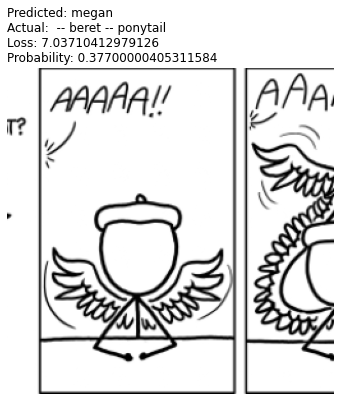

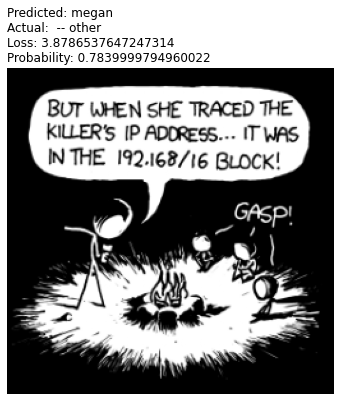

In [72]:
interp.plot_multi_top_losses(3,figsize=(6,6))

Not extremely confident about the performance of this classifier.  
Scaling/cropping issues with the data result in ambiguities regarding visible characters.




## Production

In [0]:
learn.export()